In [11]:
import pandas as pd

test_set = pd.read_csv("./test_set.csv")
train_set = pd.read_csv("./train_set.csv")

all_data = pd.concat([test_set, train_set])

all_data["verif"] = pd.Categorical(all_data["verif"])
all_data["personal"] = pd.Categorical(all_data["personal"])
all_data["difficulty"] = pd.Categorical(all_data["difficulty"])
all_data["annotator"] = pd.Categorical(all_data["annotator"])

all_data.nunique()

thread_id           31
comment_id        1486
sentence          9968
comment           1485
id               10126
verif                3
personal             2
difficulty           2
annotator            2
annotation_id    10126
created_at        7599
updated_at        7599
lead_time         6002
dtype: int64

## Inter-annotator agreement

There are two annotators, so we first calculate Cohen's $\kappa$ to
determine inter-annotator reliability.

In [12]:
from sklearn.metrics import cohen_kappa_score

# Some info on the annotators
annotator_count = all_data.groupby(by="annotator")["id"].count().to_dict()

# Find sentences annotated by both annotators
both_annotated = all_data[all_data.annotator == 1] \
    .merge(all_data[all_data.annotator == 2], how='inner', on='sentence') \
    [['sentence', 'verif_x', 'verif_y', 'personal_x', 'personal_y']]

verif_kappa = cohen_kappa_score(both_annotated['verif_x'], both_annotated['verif_y'])

def kappa_judgment(kappa):
    if kappa < 0:
        return "non-existent"
    elif kappa <= 0.20:
        return "slight"
    elif kappa <= 0.40:
        return "fair"
    elif kappa <= 0.60:
        return "moderate"
    elif kappa <= 0.80:
        return "substantial"
    else:
        return "almost perfect"

print(
    f"Annotator 1 annotated {annotator_count[1]:,} sentences, annotator 2 annotated {annotator_count[2]:,}.",
    f"\n{len(both_annotated)} sentences were annotated by both annotators.",
    f"\nOn these {len(both_annotated)} sentences, inter-annotator agreement was {kappa_judgment(verif_kappa)} (Cohen's κ = {verif_kappa:.03f})."
)

Annotator 1 annotated 5,584 sentences, annotator 2 annotated 4,542. 
135 sentences were annotated by both annotators. 
On these 135 sentences, inter-annotator agreement was fair (Cohen's κ = 0.387).


From this, we see that there are very few sentences that are annotated by both
annotators, and between these, the inter-annotator agreement is only "fair"
(Cohen's κ = 0.387). Note that this is the annotation on just verifiability, not
taking into account experientiality. We assume the score would be even lower if
this were taken into account as well.

## Class balance

Next, we check class balance. For this, we first check verifiability and
experientiality separately, and then check their combination.

<AxesSubplot:>

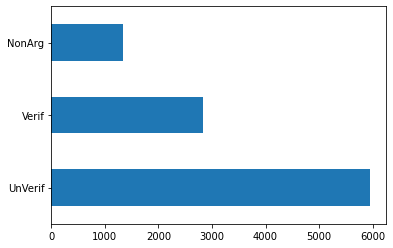

In [13]:
all_data["verif"].value_counts().plot(kind='barh')

<AxesSubplot:>

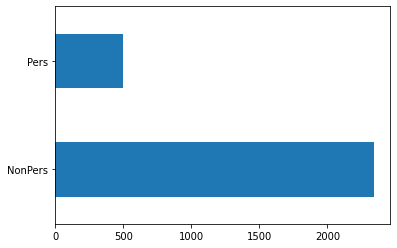

In [14]:
all_data["personal"].value_counts().plot(kind='barh')

<AxesSubplot:>

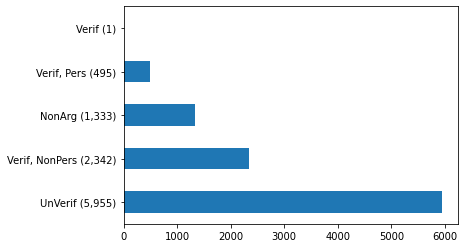

In [15]:
# Combine classes
all_data['combined_label'] = all_data['verif'].astype(str) + all_data['personal'].astype(str).map(lambda x: '' if x == 'nan' else ', ' + x)
n_combined_labels = all_data['combined_label'].value_counts().to_dict()

# Add counts to labels
all_data['combined_label'] = all_data['combined_label'].map(lambda l: f"{l} ({n_combined_labels[l]:,})")

# Plot
all_data["combined_label"].value_counts().plot(kind='barh')